# Import Libraries and Modules

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.svm import SVR 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential 
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.layers import Dropout
import yfinance as yf
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

# Data Collection, Exploration and Preprocessing

**Data Collection**

Historical data from the stock market can be accessed through various platforms. In our search, we considered platforms like Kaggle, Alpha_Vantage, and Market Index. Ultimately, we opted to obtain the data using the built-in Python library called yfinance.

**Dataset Characteristics**

     Date :  Calendar date of the trading day 
     Open : Opining price of the trading day 
     High : Highest price of the stock traded during the day
     Low : Lowest price of the stock traded during the day
     Close : Closing price of the trading day
     Adj Close : Adjusted closing price of the trading day
     Volume : Number of shares traded in exchange during the day

**Data Download**

In [80]:
# Set the desired ASX stock symbol here we have used BHP
symbol = "bhp.AX"

# Please uncomment the following line if you would like to conduct the research on a different stock
# symbol = input("Please enter ASX ticker followed by .AX:") 

# Define the date range for historical data
start_date = "2010-01-01" 
end_date = datetime.now().strftime("%Y-%m-%d")

# Download historical stock data using yfinance
data = yf.download(symbol, start=start_date, end=end_date)

# Convert to Data Frame
bhp = pd.DataFrame(data)


[*********************100%%**********************]  1 of 1 completed


**Data Exploration and Preprocessing**

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,39.947372,40.423939,39.909992,40.255737,19.880653,3949861
2010-01-05,40.648205,40.779026,40.395905,40.442627,19.972952,9721826
2010-01-06,40.722958,40.975258,40.685581,40.947224,20.222153,6951354
2010-01-07,41.031322,41.246246,40.881813,40.900501,20.199078,7091269
2010-01-08,40.825748,40.993946,40.648205,40.760338,20.129854,4906718


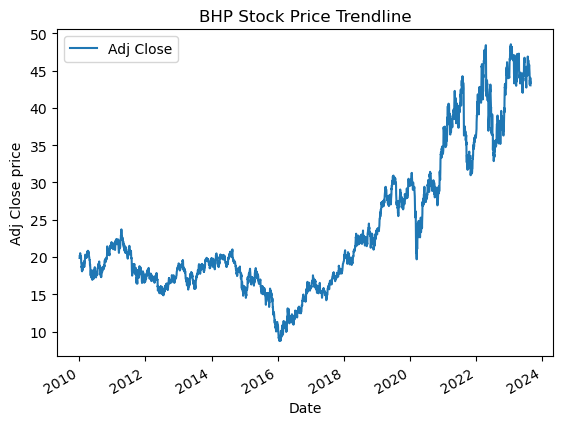

In [81]:
# BHP sample data and trendline visualization
display(bhp.head())
df_s = bhp.drop(columns = ['Open','High', 'Low', 'Close', 'Volume'])
plot = df_s.plot(title="BHP Stock Price Trendline")
plot.set_xlabel("Date")
plot.set_ylabel("Adj Close price")    
plt.show()

In [82]:
#Check shpae of the data
print("BHP selected data has rows : {} and cloumns : {} ".format(bhp.shape[0], bhp.shape[1]))


BHP selected data has rows : 3450 and cloumns : 6 


In [83]:
#checking for null values
print("BHP data has missing values : {}".format(bhp.isnull().values.any()))


BHP data has missing values : False


In [84]:
#Basic info
display(bhp.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3450 entries, 2010-01-04 to 2023-08-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3450 non-null   float64
 1   High       3450 non-null   float64
 2   Low        3450 non-null   float64
 3   Close      3450 non-null   float64
 4   Adj Close  3450 non-null   float64
 5   Volume     3450 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 188.7 KB


None

In [85]:
# Statistical data
print("BHP - Statistics:")
display(bhp.describe())


BHP - Statistics:


,Open,High,Low,Close,Adj Close,Volume
count,3450.000000,3450.000000,3450.000000,3450.000000,3450.000000,3.450000e+03
mean,34.464863,34.709914,34.205271,34.454358,23.584141,9.654942e+06
std,7.789778,7.828379,7.743033,7.784895,9.528315,7.532299e+06
min,14.150000,14.460000,14.060000,14.200000,8.751180,0.000000e+00
25%,29.814011,30.063236,29.581104,29.818519,17.062300,6.109337e+06
50%,34.649090,34.868683,34.382772,34.625528,19.750158,8.276642e+06
75%,39.465001,39.747949,39.237198,39.537500,28.981165,1.150085e+07
max,54.040001,54.549999,53.610001,54.060001,48.519943,3.274170e+08


**Correlation Analysis**

In the realm of statistical analysis, correlation signifies the connection between variables. When the correlation coefficient is positively correlated, it indicates that both values are moving in the same direction. A coefficient of exactly one implies a perfect positive correlation. Conversely, negatively correlated values move in opposite directions.

The coefficient varies between -1 and 1, with 0 denoting no meaningful relationship between the variables.

<Axes: title={'center': 'Correlation of BHP with Adj Close'}>

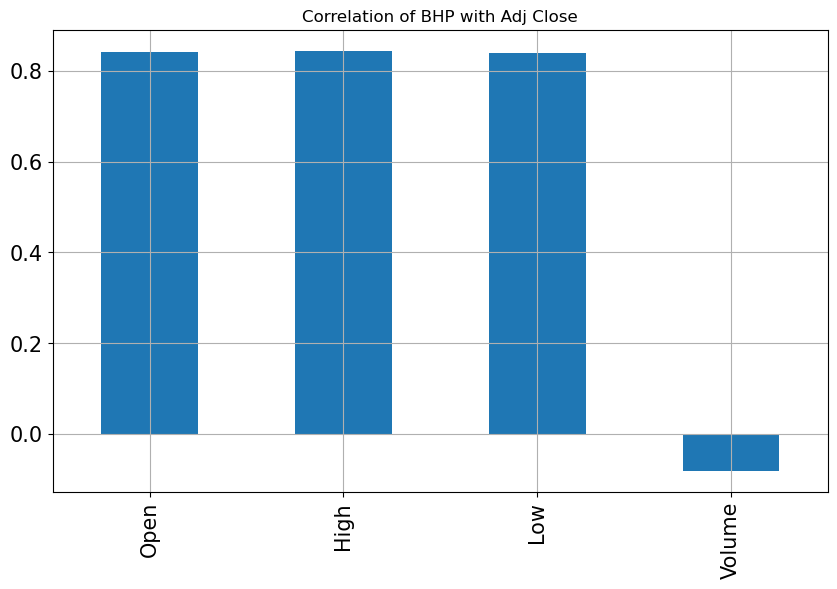

In [86]:
#correlating adj_close to other columns
#droping adj_close and close columns
s = bhp.drop(columns=['Adj Close', 'Close'], axis=1)
s.corrwith(bhp['Adj Close']).plot.bar(
                figsize = (10, 6), title = "Correlation of BHP with Adj Close", fontsize = 15,
                rot = 90, grid = True)

<Axes: >

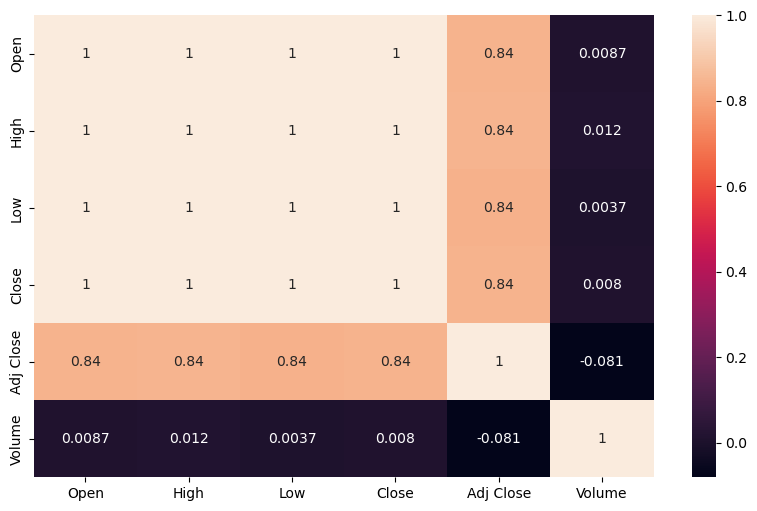

In [87]:
# Plotting Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(bhp.corr(), annot = True)

In [88]:
matrix_corr = bhp.corr()
coef = matrix_corr['Adj Close'].sort_values(ascending=False)

In [89]:
#Possitively correleated values
possitive_corr = coef[coef>0]
possitive_corr

Adj Close    1.000000
High         0.844195
Close        0.841516
Open         0.841134
Low          0.839247
Name: Adj Close, dtype: float64

In [90]:
#Negatively correlated values
negative_corr = coef[coef<0]
negative_corr

Volume   -0.081224
Name: Adj Close, dtype: float64

# Feature selection/Technical indicator selection

Technical indicators for ASX stocks are analytical tools used by traders and investors to assess market trends and make informed decisions. These indicators, derived from price and volume data, offer insights into price movements, momentum, volatility, and other factors influencing stock performance.

    # Relative Strength Index (RSI)
    # Simple Mean Average (SMA)
    # Standard Deviation 

Technical indicators calculated based on the target. Our target here is Adj Close



In [91]:
#Technical indicatiors methods
def get_RSI(df, periods=14):

    # wilder's RSI
    delta = df.diff()
    up, down = delta.copy(), delta.copy()

    up[up < 0] = 0
    down[down > 0] = 0

    rollUp = up.ewm(com=periods,adjust=False).mean()
    rollDown = down.ewm(com=periods, adjust=False).mean().abs()

    RSI = 100 - 100 / (1 + rollUp / rollDown)
    
    return RSI


def get_SMA(df, peroids=15):

    SMA = df.rolling(window=peroids, min_periods=peroids, center=False).mean()
    
    return SMA

def get_STDEV(df, periods=5):

    STDEV = df.rolling(periods).std()
   
    return STDEV

 

In [92]:
# calculates Technical indicators for the given dataframe

def calc_Tech_ind_add_col(df, original_df):

    print("Calculating technical indicators of given stock price")

    
    final_df = original_df
    
    final_df['RSI'] = get_RSI(df)
    print("RSI column added")
    final_df['SMA'] = get_SMA(df)
    print("SMA column added")
    final_df['STDEV'] = get_STDEV(df)
    print("STDEV column added")
   
    
    return final_df
    
    
    

# Normalize the Data

In [93]:
# In this step we would perform feature scaling/normalization of feature variables using sklearn's MinMaxScaler function.
def normalize_featuresDF(df):

    scaler = MinMaxScaler()
    feature_columns = df.columns
    feature_minmax_data = scaler.fit_transform(df)
    normalized_features_df = pd.DataFrame(columns=feature_columns, data=feature_minmax_data, index=df.index)
    
    
    return normalized_features_df


# Split the data into Train, Test and Validation sets
Here we are spliting the data into 3 different sets.
1. Training set
2. Testing set
3. Validation set

**split validation set from complete data**

In [94]:
def split_ValidationSet(features_df, target_df, length=90):
    """
    method is to separate validation set from the complete df

    """
    #need to shift target array because we are prediction n + 1 days price
    target_df = target_df.shift(-1)
    #split validation set . we are spliting 10% latest data for validation.
    #target
    validation_y = target_df[-length:-1]
    validation_x = features_df[-length:-1]
    
    return validation_x, validation_y

#Now get final_features_df and final_target_df by excluding validation set
def split_Final_df(normalized_features_df, target_df, v_length=90):
    """
    This method captures remaining data after the validation set.

    """
    final_features_df = normalized_features_df[:-v_length]
    final_target_df = target_df[:-v_length]
    
    return final_features_df, final_target_df

**Train and Test split using Sklearn's Timeseries split**

In [95]:
#Split final set into training and testing sets
#splitting training and testing set using sklearn's TimeSeries split
'''def split_Train_Test_DF(final_features_df, final_target_df, n_splits=10):

    ts_split = TimeSeriesSplit(n_splits)
    for train_index, test_index in ts_split.split(final_features_df):
        x_train, x_test = final_features_df[:len(train_index)], final_features_df[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = final_target_df[:len(train_index)].values.ravel(), final_target_df[len(train_index): (len(train_index)+len(test_index))].values.ravel()
        
    return x_train, y_train, x_test, y_test
'''

def split_Train_Test_DF(final_features_df, final_target_df, n_splits=10):

    ts_split = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in ts_split.split(final_features_df):
        x_train, x_test = final_features_df.iloc[train_index], final_features_df.iloc[test_index]
        y_train, y_test = final_target_df.iloc[train_index].values.ravel(), final_target_df.iloc[test_index].values.ravel()
        
    return x_train, y_train, x_test, y_test

**Visualizing the datasets for sanity check**

In [96]:
def plot_3DataSets():
    """
    Method displays the plot of the 3 different sets into single plot.
    This is just for sanity check.
    This is time series data so, sets should not be mixed.
    
    """
    t=y_test.astype(np.float)
    v = target_df[-90:-1].values.ravel()
    plt.plot(y_train, label='trainning_set')
    plt.plot([None]*len(y_train) + [x for x in t], label='test_set')
    plt.plot([None]*(len(y_train)+len(t)) + [x for x in v], label='validation_set')
    plt.xlabel('Days')
    plt.ylabel('price')
    plt.title('Split dataset into training/validation/test set')
    plt.legend()


# Implementing model prediction and evaluation

**Method for validating result with evaluation metrics**

In [97]:
#Method to evaluate the benchmark model and solution model with validate data set
def model_validateResult(model, model_name):

    if model_name in [ "LSTM", "LSTM_Tuned"]:
        x_train_t, x_test_t, validation_x_t, validation_y_t = convert_LSTM_data(x_train, x_test, validation_x, validation_y)
        model = model(x_train, y_train, validation_x)
        prediction = model.predict(validation_x_t)
    else:
        model = model(x_train, y_train, validation_x)
        prediction = model.predict(validation_x)
    
    RMSE_Score = np.sqrt(mean_squared_error(validation_y, prediction))
    
    R2_Score = r2_score(validation_y, prediction)
    
    #Ploting trendline for actual vs prediction
    plt.plot(validation_y.index, prediction,'r', label='Predicted')
    plt.plot(validation_y.index, validation_y,'b', label='Actual')
    plt.plot(figsize = (15,8))
    plt.ylabel('Price')
    plt.xlabel('Date')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.title(model_name + ' Predict vs Actual')
    plt.legend(loc='upper right')

    plt.show()
    print(model_name + ' RMSE: ', RMSE_Score)
    print(model_name + ' R2 score: ', R2_Score)
    
    return RMSE_Score, R2_Score


#Method to evaluate the final model with testing data set
def bestModel_validateResult(model, model_name):

    # giving testing set for the evaluation 
    model = model(x_train, y_train, x_test)
    prediction = model.predict(x_test)
    
    RMSE_Score = np.sqrt(mean_squared_error(y_test, prediction))
    
    R2_Score = r2_score(y_test, prediction)
    
    plt.title(model_name + 'Prediction Vs Actual')
    plt.plot(y_test, label='test data')
    plt.plot(prediction, label='prediction')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    

    print(model_name + ' RMSE: ', RMSE_Score)
    print(model_name + ' R2 score: ', R2_Score)
     
    return RMSE_Score, R2_Score


def value_Compare(model):

    model = model(x_train, y_train, x_test)
    prediction = model.predict(x_test)
    col1 = pd.DataFrame(y_test, columns=['True_value'])
    col2 = pd.DataFrame(prediction, columns = ['Predicted_value'])
    df = pd.concat([col1, col2], axis=1)
    
    return df



#  Build Models
Here we are going to introcude methods to impliment benchmark model and solution models.
Result of methods will be RMSE and R2 score with Plot.

**Benchmark Model**
DecisionTreeRegressor

Decision Tree Regressor is a machine learning algorithm used for regression tasks. It models decisions based on splitting data into branches, where each branch represents a decision path. It works by recursively partitioning the data into subsets based on features, aiming to minimize the variance of the target variable within each subset. Decision trees are easy to understand but can be prone to overfitting.

Think of this like a game of 20 questions. You ask yes/no questions based on the data, and each answer guides you to the final prediction. It's simple and can help you understand what's driving a certain outcome. Just be careful not to ask too many questions, or you might overthink it!

In [98]:

#modeling DecisionTreeRegressor with default parameters for benchmark

def model_Benchmark_DTR(x_train, y_train, validation_x, random_state=0):

    #initialize DTR
    dtr = DecisionTreeRegressor(random_state=42)   
    #fit the data
    model = dtr.fit(x_train, y_train)
    
    return model

**Solution Model**

**Support Vector Regressor (SVR)**

SVR is a machine learning algorithm used for regression tasks. It works by finding a "support vector" that best fits the data points, with the goal of minimizing prediction errors while allowing for some tolerance. SVR is particularly useful for nonlinear data and can handle both linear and nonlinear relationships.

Think of SVR like finding the best-fitting line that comes as close as possible to your data points, allowing for a little bit of wiggle room. It's good for figuring out trends in data, even if they're not a simple straight line.

In [99]:
def model_SVR(x_train, y_train, validation_x):
    
    svr_model = SVR(kernel='linear')
    model = svr_model.fit(x_train, y_train)
#     prediction = model.predict(validation_x)
    
    return model

def model_SVRTuning(x_train, y_train, validation_x):

    hyperparameters_linearSVR = {
        'C':[0.5, 1.0, 10.0, 50.0, 100.0, 120.0,150.0, 300.0, 500.0,700.0,800.0, 1000.0],
        'epsilon':[0, 0.1, 0.5, 0.7, 0.9],
    }
    
    grid_search_SVR_feat = GridSearchCV(estimator=model_SVR(x_train, y_train, validation_x),
                           param_grid=hyperparameters_linearSVR,
                           cv=TimeSeriesSplit(n_splits=10),
    )

    model = grid_search_SVR_feat.fit(x_train, y_train)
    print(grid_search_SVR_feat.best_params_)
    
    return model

**Random Forest**

Random Forest is an ensemble learning algorithm that combines multiple decision trees to make more accurate predictions. Each tree is trained on a random subset of the data and contributes to the final prediction. Random Forest is robust, handles complex relationships well, and reduces overfitting by averaging the predictions of multiple trees.

Picture a group of decision-makers (trees) getting together to vote on a decision. Each decision-maker focuses on different aspects, and by taking everyone's opinion into account, you get a well-rounded prediction that's often more accurate.

In [100]:
def model_randomForest(x_train, y_train, validation_x):
    
    randomForest_model = RandomForestRegressor(n_estimators=60, random_state=42)
    model = randomForest_model.fit(x_train, y_train)
#     prediction = model.predict(validation_x)
    
    return model

def model_randomForestTuning(x_train, y_train, validation_x):

    hyper_parameters = {
    'n_estimators':[10,15,20, 50, 100],
    'max_features':['auto','sqrt','log2'],
    'max_depth':[2, 3, 5, 7,10,13, 15, 20],
    }
    
    grid_search_RF_feat = GridSearchCV(estimator=model_randomForest(x_train, y_train, validation_x),
                           param_grid=hyper_parameters,
                           cv=TimeSeriesSplit(n_splits=10),
        )
    model = grid_search_RF_feat.fit(x_train, y_train)
    print(model.best_params_)
    
    return model

**LSTM**

LSTM is a type of recurrent neural network (RNN) architecture designed to capture patterns in sequences of data. It's well-suited for tasks involving time series data, natural language processing, and more. LSTMs have a memory mechanism that helps them capture long-range dependencies and avoid the vanishing gradient problem in traditional RNNs.

Imagine LSTM as a smart system that remembers information from the past to predict what comes next. It's great for handling things like predicting future values in time-based data (like stock prices) or understanding patterns in text.

In [101]:
#LSTM model need feature input in array
#convert data to array

def convert_LSTM_data(x_train, x_test, validation_x, validation_y):
# def convert_LSTM_data():
    
    x_train =np.array(x_train)
    x_test =np.array(x_test)
    validation_x =np.array(validation_x)
    validation_y = np.array(validation_y)
    
    #reshape sets
   
    #shpae pf LSTM is (number of records, number of times steps, feature dimension)   
    x_train_lstm = np.reshape(x_train, (x_train.shape[0],1,  x_train.shape[1]))
    x_test_lstm = np.reshape(x_test, (x_test.shape[0],1, x_test.shape[1]))
    
    validation_x_lstm = np.reshape(validation_x, (validation_x.shape[0], 1, validation_x.shape[1]))
    validation_y_lstm = np.reshape(validation_y, (validation_y.shape[0],1, validation_y.shape[1]))
    
    return x_train_lstm, x_test_lstm, validation_x_lstm, validation_y_lstm


In [102]:
# LSTM model prediction funciton
def model_LSTM(x_train, y_train, validation_x, convertion_model = convert_LSTM_data):

    K.clear_session()
    x_train_t, x_test_t, validation_x_t, validation_y_t = convertion_model(x_train, x_test, validation_x, validation_y)
    # instantiate the Sequential class
    model = Sequential()
    #Create LSTM and Drop out Layers, return_sequences = True because we will add more layers to the model
    #input_shape(number of time steps, number of indicators/features)
    model.add(LSTM(units=50, input_shape=(1, x_train.shape[1]), activation='relu', return_sequences=True))
    #dropout layter is to avoid over-fitting
    model.add(Dropout(0.2))
    #Add few more laters and dropouts to the model
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    
    #Create Dense layer, number of neurons in dense layer  = 1 becasue we want to predict one value
    model.add(Dense(units = 1))
    #need to compile before training the data
    #
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    
    history_model = model.fit(x_train_t, y_train, epochs=200, batch_size=32,callbacks=[early_stop])
#     prediction = model_lstm.predict(validation_x_t)
   
    return model



#      
# LSTM model prediction funciton
def model_LSTMTuning(x_train, y_train, validation_x, convertion_model = convert_LSTM_data):

    K.clear_session()
    x_train_t, x_test_t, validation_x_t, validation_y_t = convertion_model(x_train, x_test, validation_x, validation_y)
    # instantiate the Sequential class
    model = Sequential()
    #Create LSTM and Drop out Layers, return_sequences = True because we will add more layers to the model
    #input_shape(number of time steps, number of indicators/features)
    model.add(LSTM(units=50, input_shape=(1, x_train.shape[1]), activation='relu', return_sequences=True))
    #dropout layter is to avoid over-fitting
    model.add(Dropout(0.5))
    #Add few more laters and dropouts to the model
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.5))

    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.5))

    model.add(LSTM(units=50))
    model.add(Dropout(0.5))
    
    #Create Dense layer, number of neurons in dense layer  = 1 becasue we want to predict one value
    model.add(Dense(units = 1))
    #need to compile before training the data
    #
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
      
    history_model = model.fit(x_train_t, y_train, epochs=200, batch_size=16,callbacks=[early_stop])
 
    return model




# Implimentation

So far we have done data exploration and defined all the functions to impliment prediction models. We are going to call those methods step by steps and evaluate the benchmark and solution models.

Steps:
1. get the original data
2. feature selection / Technicla indicator
3. Selecting features and target df
4. Normalizing the data
5. Split train/test/validation sets
6. evaluating models


In [103]:
# Converting downloaded data to DataFrame and storing it in a variable named bhp
bhp = pd.DataFrame(data)

In [104]:
#checking for null values
print("BHP data has missing values : {}".format(bhp.isnull().values.any()))
#Basic info
display(bhp.info())

BHP data has missing values : False
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3450 entries, 2010-01-04 to 2023-08-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3450 non-null   float64
 1   High       3450 non-null   float64
 2   Low        3450 non-null   float64
 3   Close      3450 non-null   float64
 4   Adj Close  3450 non-null   float64
 5   Volume     3450 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 188.7 KB


None

In [105]:
#Get adj_close data for the technical indicators
df_tech = bhp['Adj Close']

#calculate technical indicators and adding indicators to the data
final_df = calc_Tech_ind_add_col(df_tech, bhp)
final_df.columns

Calculating technical indicators of given stock price
RSI column added
SMA column added
STDEV column added


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'RSI', 'SMA',
       'STDEV'],
      dtype='object')

In [106]:
#Final dataframe with all the technical indicators
final_df.tail()

,Open,High,Low,Close,Adj Close,Volume,RSI,SMA,STDEV
Date,,,,,,,,,
2023-08-21,43.599998,43.869999,43.270000,43.520000,43.520000,5588917,40.211268,44.935333,0.619394
2023-08-22,42.700001,43.459999,42.650002,43.209999,43.209999,9947256,38.393916,44.724666,0.263096
2023-08-23,43.000000,44.340000,43.000000,44.029999,44.029999,9795378,45.388883,44.603333,0.371779
2023-08-24,44.040001,44.314999,43.580002,43.779999,43.779999,7925377,43.765635,44.501333,0.305499
2023-08-25,43.000000,43.279999,42.849998,43.020000,43.020000,8985034,39.199472,44.316000,0.410329


In [107]:
#Checking no of null values in each columns
final_df.isnull().sum()

Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
RSI           1
SMA          14
STDEV         4
dtype: int64

In [108]:
#Removing null rows from final_df

final_df = final_df[33:]

In [109]:
final_df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
RSI          0
SMA          0
STDEV        0
dtype: int64

In [110]:
final_df.head()

,Open,High,Low,Close,Adj Close,Volume,RSI,SMA,STDEV
Date,,,,,,,,,
2010-02-19,38.536366,38.676533,37.826191,38.312099,18.920767,17834858,50.339756,18.666342,0.151469
2010-02-22,39.003586,39.433430,38.966209,39.396049,19.456093,13102267,58.070770,18.757408,0.281933
2010-02-23,38.919487,39.349331,38.900799,39.349331,19.433020,10727211,57.656268,18.808171,0.272343
2010-02-24,38.657845,38.779320,38.106522,38.199966,18.865391,26522283,48.526352,18.789096,0.303646
2010-02-25,38.396198,38.433578,37.798157,37.798157,18.666962,16167654,45.809418,18.772483,0.356165


# Selecting features df and target df

**Target** is Adj Close

**Features** are ['Open', 'High', 'Low', 'Volume', 'RSI', 'MACD','SMA', 'STDEV', 'Upper_Band', 'Lower_Band', 'DIFF']

In [111]:
#getting feature df from final_df
features_df = final_df[['Open', 'High', 'Low', 'Volume', 'RSI',
       'SMA', 'STDEV']]
#getting target df from final_df
target_df = final_df[['Adj Close']]

In [112]:
#Checking no of null values in each columns
final_df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
RSI          0
SMA          0
STDEV        0
dtype: int64

In [113]:
#Check sample of feature and target df
display(features_df.head(5))
display(target_df.tail(5))

,Open,High,Low,Volume,RSI,SMA,STDEV
Date,,,,,,,
2010-02-19,38.536366,38.676533,37.826191,17834858,50.339756,18.666342,0.151469
2010-02-22,39.003586,39.433430,38.966209,13102267,58.070770,18.757408,0.281933
2010-02-23,38.919487,39.349331,38.900799,10727211,57.656268,18.808171,0.272343
2010-02-24,38.657845,38.779320,38.106522,26522283,48.526352,18.789096,0.303646
2010-02-25,38.396198,38.433578,37.798157,16167654,45.809418,18.772483,0.356165


,Adj Close
Date,
2023-08-21,43.520000
2023-08-22,43.209999
2023-08-23,44.029999
2023-08-24,43.779999
2023-08-25,43.020000


# Normalizing the data

In [114]:
#normalizing features df
normalized_features_df = normalize_featuresDF(features_df)

In [115]:
#Get shape of the features and target data
print("feature_df has (rows, columns) : {} ".format(normalized_features_df.shape))
print("target_df has (rows, columns) : {} ".format(target_df.shape))

feature_df has (rows, columns) : (3417, 7) 
target_df has (rows, columns) : (3417, 1) 


In [116]:
#Look at the final feature df and target df before splitting training/test/validation sets
display(normalized_features_df)
display(target_df)

,Open,High,Low,Volume,RSI,SMA,STDEV
Date,,,,,,,
2010-02-19,0.611340,0.604054,0.600915,0.054471,0.504230,0.244675,0.046686
2010-02-22,0.623053,0.622934,0.629740,0.040017,0.620390,0.247019,0.091013
2010-02-23,0.620945,0.620836,0.628086,0.032763,0.614162,0.248325,0.087755
2010-02-24,0.614386,0.606618,0.608003,0.081005,0.476983,0.247835,0.098391
2010-02-25,0.607826,0.597994,0.600206,0.049379,0.436160,0.247407,0.116235
...,...,...,...,...,...,...,...
2023-08-21,0.738280,0.733599,0.738559,0.017070,0.352047,0.920730,0.205671
2023-08-22,0.715718,0.723372,0.722882,0.030381,0.324741,0.915308,0.084613
2023-08-23,0.723239,0.745323,0.731732,0.029917,0.429842,0.912186,0.121540


,Adj Close
Date,
2010-02-19,18.920767
2010-02-22,19.456093
2010-02-23,19.433020
2010-02-24,18.865391
2010-02-25,18.666962
...,...
2023-08-21,43.520000
2023-08-22,43.209999
2023-08-23,44.029999


# Splitting train, test, validation sets

In [117]:
#Splitting validation sets from the final features and target df
validation_x, validation_y = split_ValidationSet(normalized_features_df, target_df)

In [118]:
print("validation_x has (rows, columns) : {} ".format(validation_x.shape))
print("validation_y has (rows, columns) : {} ".format(validation_y.shape))

validation_x has (rows, columns) : (89, 7) 
validation_y has (rows, columns) : (89, 1) 


In [119]:
#splitting train and test set from validation set

final_features_df, final_target_df = split_Final_df(normalized_features_df, target_df)

In [120]:
print("final_features_df has (rows, columns) : {} ".format(final_features_df.shape))
print("final_target_df has (rows, columns) : {} ".format(final_target_df.shape))

final_features_df has (rows, columns) : (3327, 7) 
final_target_df has (rows, columns) : (3327, 1) 


# Splitting Train and Test using Skleans TimeSeriesSplit 

In [121]:
#splitting train and test
x_train, y_train, x_test, y_test = split_Train_Test_DF(final_features_df, final_target_df)

In [122]:
print("Shape of training sets x_train : {}, y_train : {}".format(x_train.shape, y_train.shape))
print("Shape of testing sets x_train : {}, y_train : {}".format(x_test.shape, y_test.shape))

Shape of training sets x_train : (3025, 7), y_train : (3025,)
Shape of testing sets x_train : (302, 7), y_train : (302,)


C:\Users\TheCr\AppData\Local\Temp\ipykernel_16812\2488585044.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  t=y_test.astype(np.float)


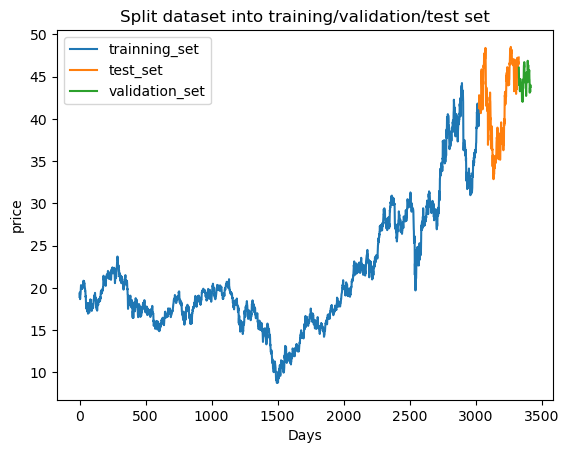

In [123]:
#Visualizing the train, test and validation sets in single plot
plot_3DataSets()

In [124]:
x_train

,Open,High,Low,Volume,RSI,SMA,STDEV
Date,,,,,,,
2010-02-19,0.611340,0.604054,0.600915,0.054471,0.504230,0.244675,0.046686
2010-02-22,0.623053,0.622934,0.629740,0.040017,0.620390,0.247019,0.091013
2010-02-23,0.620945,0.620836,0.628086,0.032763,0.614162,0.248325,0.087755
2010-02-24,0.614386,0.606618,0.608003,0.081005,0.476983,0.247835,0.098391
2010-02-25,0.607826,0.597994,0.600206,0.049379,0.436160,0.247407,0.116235
...,...,...,...,...,...,...,...
2022-01-31,0.799699,0.795710,0.796207,0.115022,0.668415,0.796494,0.211752
2022-02-01,0.784407,0.774009,0.774716,0.065115,0.546656,0.796718,0.248121
2022-02-02,0.798195,0.789224,0.793932,0.075045,0.593221,0.798198,0.219819


# Model Validation
Getting the RMSE and R2 score by predicting the models.

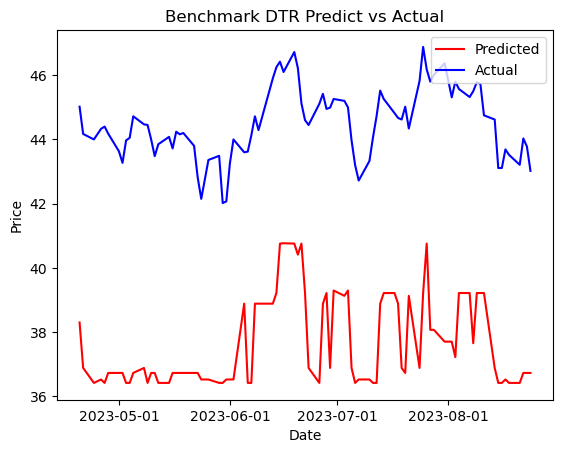

Benchmark DTR RMSE:  6.944611509639446
Benchmark DTR R2 score:  -39.66642808715832


In [125]:
#Benchmark - DTR model RMSE and R2 score with plot
RMSE_Score, R2_Score = model_validateResult(model_Benchmark_DTR, model_name = "Benchmark DTR")

In [126]:
#Benchmark Model
print("RMSE_Score : ", RMSE_Score)
print("R2_Score : ", R2_Score)

RMSE_Score :  6.944611509639446
R2_Score :  -39.66642808715832


# Solution Models validation

**SVR**

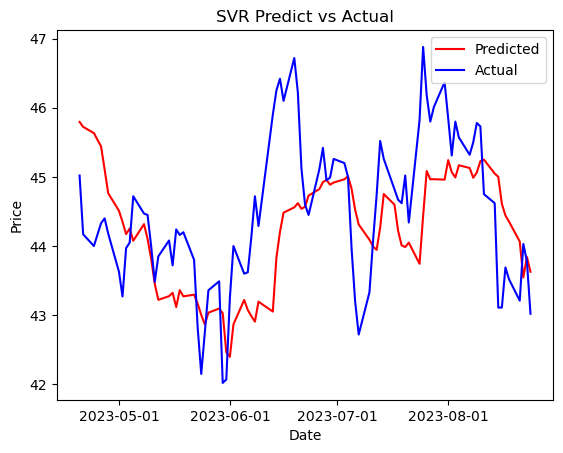

SVR RMSE:  1.0114921639334846
SVR R2 score:  0.13728934518600466


In [127]:
#SVR model
RMSE_Score, R2_Score = model_validateResult(model_SVR, model_name = "SVR")

In [128]:
#SVR Model
print("SVR RMSE_Score : ", RMSE_Score)
print("SVR R2_Score : ", R2_Score)

SVR RMSE_Score :  1.0114921639334846
SVR R2_Score :  0.13728934518600466


{'C': 1000.0, 'epsilon': 0.1}


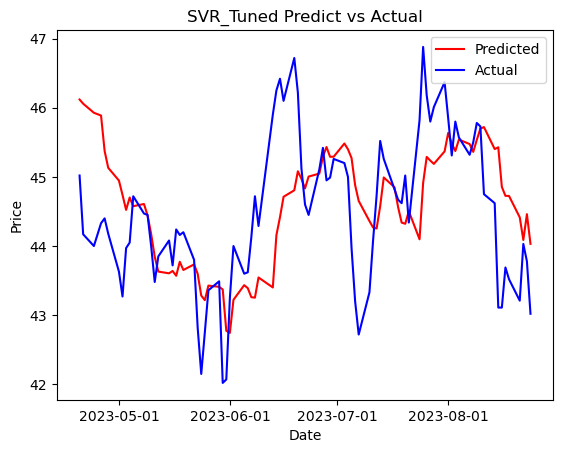

SVR_Tuned RMSE:  0.987055757419912
SVR_Tuned R2 score:  0.17846988393794028


In [129]:
#SVR model Tuning
RMSE_Score, R2_Score = model_validateResult(model_SVRTuning, model_name = "SVR_Tuned")

In [130]:
#SVR Tuning Model
print("SVR Tuned RMSE_Score : ", RMSE_Score)
print("SVR Tuned R2_Score : ", R2_Score)

SVR Tuned RMSE_Score :  0.987055757419912
SVR Tuned R2_Score :  0.17846988393794028


**Random Forest**

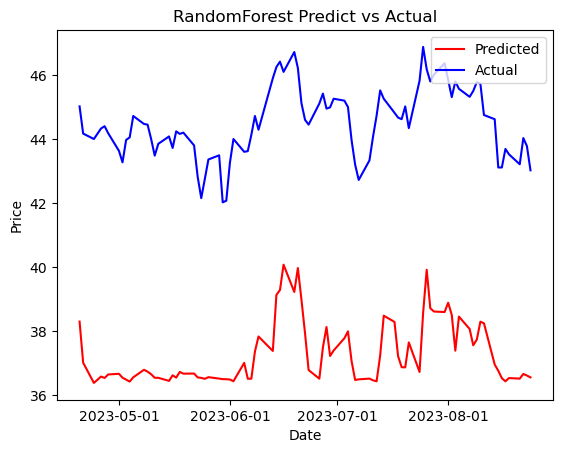

RandomForest RMSE:  7.245245337899237
RandomForest R2 score:  -43.263556798294886


In [131]:
#RF model
#Validate result for randomForest
RMSE_Score, R2_Score = model_validateResult(model_randomForest, "RandomForest")

In [132]:
#RF Model
print("RF RMSE_Score : ", RMSE_Score)
print("RF R2_Score : ", R2_Score)

RF RMSE_Score :  7.245245337899237
RF R2_Score :  -43.263556798294886


c:\Users\TheCr\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\TheCr\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\TheCr\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestR

{'max_depth': 20, 'max_features': 'auto', 'n_estimators': 50}


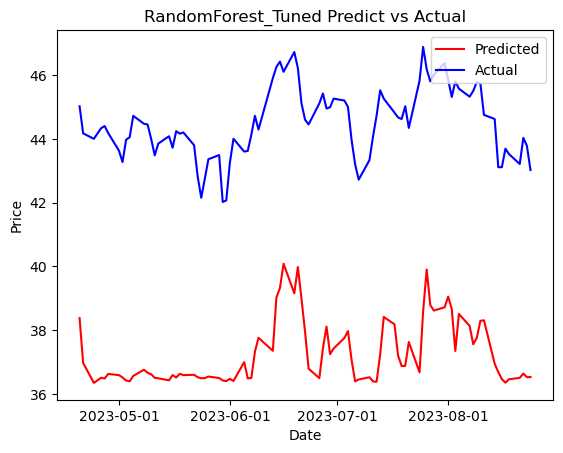

RandomForest_Tuned RMSE:  7.254898515669042
RandomForest_Tuned R2 score:  -43.38158416872369


In [133]:
#Tuned RF model
RMSE_Score, R2_Score = model_validateResult(model_randomForestTuning, "RandomForest_Tuned")

In [134]:
#RF Model
print("RF Tuned RMSE_Score : ", RMSE_Score)
print("RF Tuned R2_Score : ", R2_Score)

RF Tuned RMSE_Score :  7.254898515669042
RF Tuned R2_Score :  -43.38158416872369


**LSTM**

Prior to validating the LSTM model we need to format the data as per LSTM. We are passing convertion method here.

Epoch 1/200
95/95 [==============================] - 10s 7ms/step - loss: 383.1427
Epoch 2/200
95/95 [==============================] - 1s 8ms/step - loss: 96.5295
Epoch 3/200
95/95 [==============================] - 1s 7ms/step - loss: 64.0025
Epoch 4/200
95/95 [==============================] - 1s 6ms/step - loss: 53.6254
Epoch 5/200
95/95 [==============================] - 1s 6ms/step - loss: 43.9718
Epoch 6/200
95/95 [==============================] - 1s 7ms/step - loss: 34.8210
Epoch 7/200
95/95 [==============================] - 1s 7ms/step - loss: 28.8648
Epoch 8/200
95/95 [==============================] - 1s 7ms/step - loss: 23.1754
Epoch 9/200
95/95 [==============================] - 1s 6ms/step - loss: 18.7685
Epoch 10/200
95/95 [==============================] - 1s 7ms/step - loss: 15.1036
Epoch 11/200
95/95 [==============================] - 1s 7ms/step - loss: 12.9183
Epoch 12/200
95/95 [==============================] - 1s 8ms/step - loss: 10.7543
Epoch 13/200
95/95 [===

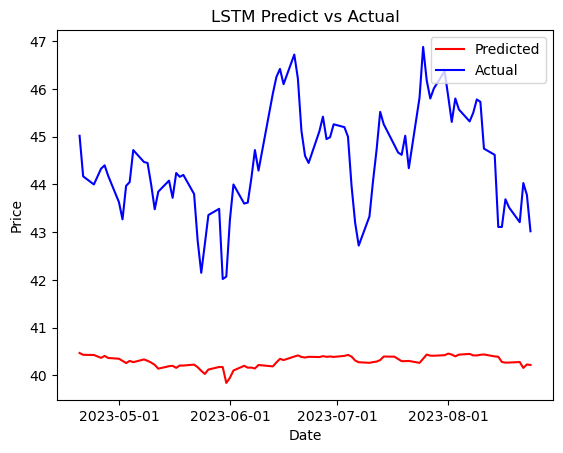

LSTM RMSE:  4.305722355169942
LSTM R2 score:  -14.632634008717364


In [135]:
#Before validating the model we need to format the data as per LSTM.
RMSE_Score, R2_Score = model_validateResult(model_LSTM, "LSTM")

In [136]:
#LSTM Model
print("LSTM RMSE_Score : ", RMSE_Score)
print("LSTM R2_Score : ", R2_Score)

LSTM RMSE_Score :  4.305722355169942
LSTM R2_Score :  -14.632634008717364


Epoch 1/200
190/190 [==============================] - 11s 7ms/step - loss: 259.0457
Epoch 2/200
190/190 [==============================] - 1s 6ms/step - loss: 64.7498
Epoch 3/200
190/190 [==============================] - 1s 6ms/step - loss: 50.2262
Epoch 4/200
190/190 [==============================] - 1s 7ms/step - loss: 42.3241
Epoch 5/200
190/190 [==============================] - 1s 6ms/step - loss: 37.0417
Epoch 6/200
190/190 [==============================] - 1s 6ms/step - loss: 28.1537
Epoch 7/200
190/190 [==============================] - 1s 6ms/step - loss: 23.5773
Epoch 8/200
190/190 [==============================] - 1s 6ms/step - loss: 20.4153
Epoch 9/200
190/190 [==============================] - 1s 7ms/step - loss: 17.9219
Epoch 10/200
190/190 [==============================] - 1s 6ms/step - loss: 17.3830
Epoch 11/200
190/190 [==============================] - 1s 6ms/step - loss: 16.8028
Epoch 12/200
190/190 [==============================] - 1s 6ms/step - loss: 15.8768

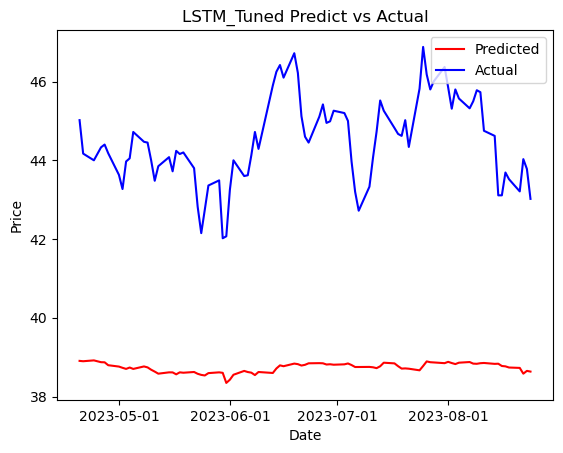

LSTM_Tuned RMSE:  5.840280529379401
LSTM_Tuned R2 score:  -27.76123516942639


In [137]:
#LSTM Tuned
RMSE_Score, R2_Score = model_validateResult(model_LSTMTuning, "LSTM_Tuned")

In [138]:
#LSTM Tuned Model
print("LSTM Tuned RMSE_Score : ", RMSE_Score)
print("LSTM Tuned R2_Score : ", R2_Score)

LSTM Tuned RMSE_Score :  5.840280529379401
LSTM Tuned R2_Score :  -27.76123516942639



# Best Model
**SVR vs Benchmark- DecisionTreeRegressor**

Based on the RSME Scroe and R2 Score, SVR with tuned model is the best performing model.


{'C': 1000.0, 'epsilon': 0.1}
SVR_Best Model RMSE:  1.2769228141432918
SVR_Best Model R2 score:  0.9097717972049777


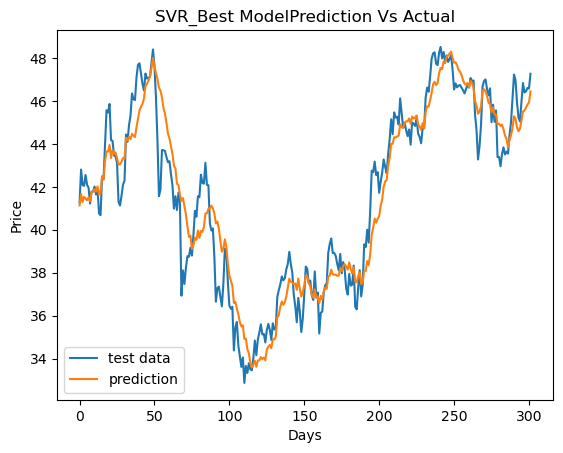

In [139]:
#SVR_Tuning model validation with test data
RMSE_Score, R2_Score = bestModel_validateResult(model_SVRTuning, model_name = "SVR_Best Model")


# Conclusion


Based on the RSME Scroe and R2 Score, SVR with tuned model is the best performing model.

As our time was limited, we concluded our investigation at this point. However, additional research holds potential for enhancing model accuracy. For instance, incorporating additional technical indicators or delving deeper into time series analysis could contribute significantly to refining the model's performance.